In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/airline_passengers.csv',index_col='Month')

df

,Thousands of Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


In [4]:
from sklearn.preprocessing import MinMaxScaler
train=df[:132]
test=df[132:]
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)

In [5]:
n_input=12
n_features=1

In [6]:
train_generator=TimeseriesGenerator(scaled_train,
                                     scaled_train,
                                      n_input,
                                      batch_size=1)

In [7]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dense(1))

In [8]:
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 12, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 10)                2440      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 73,451
Trainable params: 73,451
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(train_generator,epochs=20)

Epoch 1/20
120/120 [==============================] - 6s 16ms/step - loss: 0.0536
Epoch 2/20
120/120 [==============================] - 2s 15ms/step - loss: 0.0132
Epoch 3/20
120/120 [==============================] - 2s 16ms/step - loss: 0.0114
Epoch 4/20
120/120 [==============================] - 2s 16ms/step - loss: 0.0122
Epoch 5/20
120/120 [==============================] - 2s 16ms/step - loss: 0.0109
Epoch 6/20
120/120 [==============================] - 2s 16ms/step - loss: 0.0121
Epoch 7/20
120/120 [==============================] - 2s 16ms/step - loss: 0.0090
Epoch 8/20
120/120 [==============================] - 2s 17ms/step - loss: 0.0093
Epoch 9/20
120/120 [==============================] - 2s 16ms/step - loss: 0.0096
Epoch 10/20
120/120 [==============================] - 2s 16ms/step - loss: 0.0079
Epoch 11/20
120/120 [==============================] - 2s 16ms/step - loss: 0.0097
Epoch 12/20
120/120 [==============================] - 2s 16ms/step - loss: 0.0087
Epoch 13/20
1

In [10]:
test_predictions = []
#Select last n_input values from the train data
first_eval_batch = scaled_train[-n_input:]
#reshape the data into LSTM required (#batch,#timesteps,#features)
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):
# get prediction, grab the exact number using the [0]
  pred = model.predict(current_batch)[0]
# Add this prediction to the list
  test_predictions.append(pred)
# The most critical part, update the (#batch,#timesteps,#features
# using np.append(
# current_batch[:        ,1:   ,:] ---------> read this as
# current_batch[no_change,1:end,no_change]
# (Do note the second part has the timesteps)
# [[pred]] need the double brackets as current_batch is a 3D array
# axis=1, remember we need to add to the second part i.e. 1st axis
  current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

1/1 [==============================] - 0s 19ms/step


In [11]:
test_predictions

[array([0.75916344], dtype=float32),
 array([0.7948391], dtype=float32),
 array([0.88553494], dtype=float32),
 array([0.90374565], dtype=float32),
 array([0.9934753], dtype=float32),
 array([1.0770689], dtype=float32),
 array([1.1064439], dtype=float32),
 array([1.0739608], dtype=float32),
 array([0.96318054], dtype=float32),
 array([0.8658874], dtype=float32),
 array([0.8559094], dtype=float32),
 array([0.9597105], dtype=float32)]

In [12]:
actual_predictions = scaler.inverse_transform(test_predictions)
actual_predictions

array([[449.41936487],
       [465.65178329],
       [506.91839868],
       [515.20427132],
       [556.03126967],
       [594.06636083],
       [607.4319663 ],
       [592.6521554 ],
       [542.24714661],
       [497.97876859],
       [493.43878025],
       [540.66826785]])

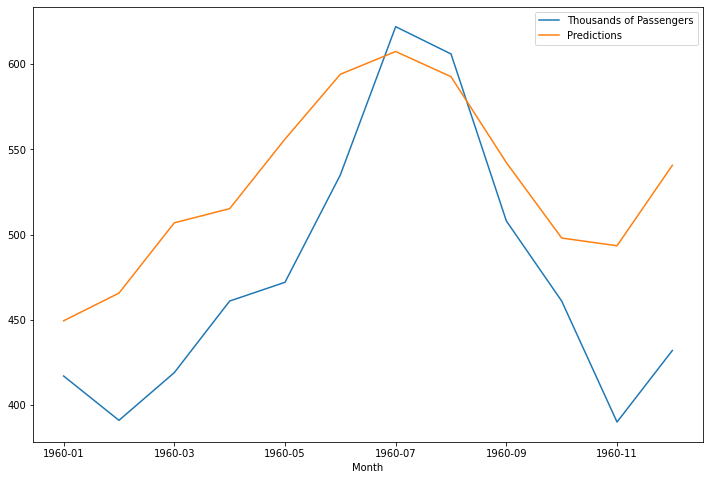

In [13]:
test['Predictions'] = actual_predictions
test.plot(figsize=(12,8));